In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
evds=evdsAPI('dsIC3fiGlu')


In [3]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4640,15-11-2023,28.6341
4641,16-11-2023,28.6679
4642,17-11-2023,28.7045
4643,20-11-2023,28.7109


In [4]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448


In [5]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04


In [6]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [7]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04


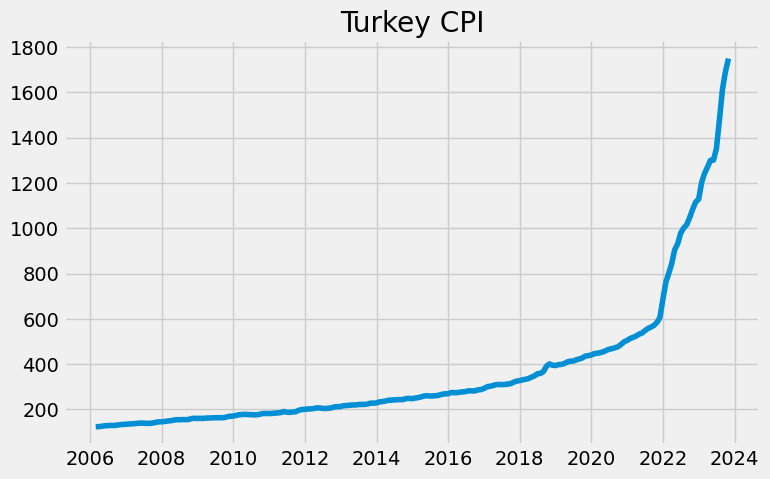

In [8]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [9]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448


In [10]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del money["Tarih"]
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
money

,Para Arzi
2006-02-28,2.423895
2006-03-31,2.494857
2006-04-30,2.521919
2006-05-31,2.751947
2006-06-30,2.791388
...,...
2023-07-31,114.784753
2023-08-31,120.253200
2023-09-30,123.493114
2023-10-31,127.637320


In [11]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(money.index)
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-07-31,117.729650
2023-08-31,123.434020
2023-09-30,126.660411
2023-10-31,130.933329


In [12]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",end="2023-10-29",freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-05-31,9.5
2023-06-30,9.5
2023-07-31,9.3
2023-08-31,9.2


In [13]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4634,07-11-2023,83.43
4635,08-11-2023,81.46
4636,09-11-2023,81.74
4637,10-11-2023,83.66


In [14]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle


brent

,TP_BRENTPETROL_EUBP
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.722381


In [15]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-28','2023-12-29' , freq='1M')

df14["Brent"]=brent["TP_BRENTPETROL_EUBP"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])

df14

,Brent
TIME,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.722381


In [16]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10
212,2023-10,1.047935e+10


In [17]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
209,2023-7,98.468952
210,2023-8,99.238055
211,2023-9,102.582870
212,2023-10,104.793503


In [18]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=pd.date_range(start="2006-02-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503


In [19]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
#pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.5
1,2006-3,17.5
2,2006-4,17.5
3,2006-5,17.5
4,2006-6,17.5
...,...,...
209,2023-7,17.5
210,2023-8,23.5
211,2023-9,31.0
212,2023-10,33.0


In [20]:
dates=pd.date_range('2006-02-28','2023-12-29' , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.5
2006-03-31,17.5
2006-04-30,17.5
2006-05-31,17.5
2006-06-30,17.5
...,...
2023-07-31,17.5
2023-08-31,23.5
2023-09-30,31.0


In [21]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
kfaiz

,Kredi Faizi
2006-02-28,17.2975
2006-03-31,17.0080
2006-04-30,16.2075
2006-05-31,16.3000
2006-06-30,19.6700
...,...
2023-07-31,45.8250
2023-08-31,45.7650
2023-09-30,56.3500
2023-10-31,59.3925


In [22]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100) (2).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",end="2023-10-01",freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-05-31,181.176925,179.718446,179.734862
2023-06-30,180.070938,186.170934,179.520633
2023-07-31,191.652101,194.140963,184.782561
2023-08-31,184.907520,183.148681,176.126980


In [23]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",end="2023-12-01",freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-07-31,29.480000
2023-08-31,37.370000
2023-09-30,39.180000
2023-10-31,38.900000


In [24]:
sanayi=pd.read_excel("C:/Users/Bora/Downloads/sanayi uretim endeksi ve degisim oranlari (2015=100).xls")
sanayi=pd.DataFrame(sanayi.iloc[8:,5])
sanayi.columns=["Sanayi"]
sanayi=sanayi.set_index(pd.date_range(start="2005-02-08",periods=len(sanayi),freq="1M"))
sanayi=sanayi.dropna()
sanayi=sanayi.astype(float)
sanayi

,Sanayi
2005-02-28,57.747916
2005-03-31,57.058754
2005-04-30,57.685141
2005-05-31,58.226534
2005-06-30,58.022939
...,...
2023-05-31,146.666835
2023-06-30,148.351267
2023-07-31,147.798299
2023-08-31,146.674452


In [25]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2023-12-01",freq="1M"))
del mfaiz["Tarih"]
mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.7600
2006-03-31,15.3300
2006-04-30,15.1750
2006-05-31,14.9250
2006-06-30,15.5840
...,...
2023-07-31,33.1250
2023-08-31,29.4125
2023-09-30,41.6560
2023-10-31,43.8925


In [26]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",end="2023-12-29",freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-07-31,7.70
2023-08-31,6.81
2023-09-30,7.30
2023-10-31,5.57


In [27]:
borc=evds.get_data(["TP.KB.A09"],startdate="28-02-2010",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2010-02-28",end="2023-11-29",freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2010-02-28,3.394344e+08
2010-03-31,3.406784e+08
2010-04-30,3.431629e+08
2010-05-31,3.405206e+08
2010-06-30,3.431419e+08
...,...
2023-06-30,2.575631e+09
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09


In [28]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",end="2023-11-29",freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-06-30,87.02
2023-07-31,81.68
2023-08-31,85.52
2023-09-30,89.55


In [29]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",end="2023-11-29",freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-06-30,51.56
2023-07-31,48.68
2023-08-31,52.39
2023-09-30,55.46


In [30]:
data=pd.DataFrame()
data["USDTL"]=df6["USD/TL"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Borç"]=borc["Borç"].shift(1)
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.dropna(axis=0)
data

,USDTL,ParaArzi,Motorin,Perakende Satış,Sanayi,Borç,Kredi,M3,REDK,REDKT,TÜFE
Tarih,,,,,,,,,,,
2011-04-30,-0.810542,1.738088,-1.218711,-0.176965,-0.162949,0.684613,2.978727,1.642254,1.593625,2.284537,0.866270
2011-05-31,-0.399628,0.113812,-1.660706,1.110822,1.016932,0.570506,3.568114,0.477281,-3.090570,-1.121135,2.420827
2011-06-30,0.415548,2.361933,2.055258,2.490629,1.895703,0.194110,3.122424,2.450559,-1.878794,-3.463549,-1.430743
2011-07-31,2.804715,2.187652,2.237631,1.258223,1.925345,0.019793,2.898935,2.189939,-3.289474,-3.817214,-0.409400
2011-08-31,3.747733,0.569285,1.664460,-0.296514,2.983648,0.318355,3.279260,0.444077,-4.213626,-5.533295,0.726069
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,11.475241,15.146856,33.393665,2.931099,-0.372743,9.689321,5.675617,15.439600,-6.136520,-5.585725,9.488824
2023-08-31,10.505114,5.943431,26.763908,-4.684198,-0.760392,2.618269,1.850455,5.968276,4.701273,7.621200,9.086793
2023-09-30,5.071342,4.764088,4.843457,-0.712124,-0.125062,4.384930,2.080815,4.845313,4.712348,5.859897,4.753114


In [31]:

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["İşsizlik"]=issizlik["İşsizlik"]
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data['Şok'] = (data.index.year.map(yearly_mean) < data['TÜFE']).astype(int)
data=data.dropna(axis=0)
data=data[['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','REDK','REDKT','Şok','M3','İşsizlik','Politika Faizi',"TÜFE"]]
data.iloc[0,4]=11.01
data.iloc[12,4]=12.3
data.iloc[24,4]=29.32
data.iloc[36,4]=7.92
data.iloc[48,4]=14.17
data.iloc[60,4]=25.45
data.iloc[72,4]=15
data.iloc[84,4]=26.56
data.iloc[96,4]=50
data.iloc[102,4]=30
data.iloc[108,4]=54
data.iloc[114,4]=34
data

,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,Şok,M3,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,3.944616,13.5140,11.01,3.604096,0.82,3.375162,-0.584687,3.267877,9.0220,-3.691204,-5.094658,1,3.413428,9.2,9.96,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.4575,0.00,-0.850238,0.73,1.804994,0.808574,1.451593,10.6275,2.179150,0.919060,0,2.079333,9.5,10.23,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,15.8900,0.00,0.128936,0.80,0.451349,0.193691,0.341852,11.3125,0.471546,0.641623,1,0.229599,9.5,10.27,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.8625,0.00,-0.863760,0.73,0.796760,0.478162,0.129671,11.0200,4.682667,5.892031,1,0.730196,9.7,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.4280,0.00,-1.367417,0.80,-0.362357,0.091080,0.468727,10.4940,1.283880,2.058652,0,-0.093468,9.7,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31,1.507585,-7.526882,3.200118,32.0225,0.00,1.434427,7.37,4.931112,2.663712,3.535416,31.4625,1.004595,-1.762413,0,4.796282,9.5,9.09,0.043076
2023-06-30,7.066073,16.807611,-0.119192,38.5600,0.00,1.148476,7.55,-1.017069,2.406884,5.711697,39.5920,-7.925087,-11.057444,0,-1.142443,9.5,12.84,3.920498
2023-07-31,11.475241,33.393665,2.931099,45.8250,34.00,-0.372743,7.70,15.146856,9.689321,5.675617,33.1250,-6.136520,-5.585725,1,15.439600,9.3,17.50,9.488824


In [32]:
'''from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
features=data.columns
train=data.iloc[:-12,:]
test=data.iloc[-12:,:]
best_mse=float("inf")
best_features=[]
for combo in combinations(features, 10):
        selected_features = list(combo)
        if 'TÜFE' not in selected_features:
            selected_features.append("TÜFE")
            
        train_subset = train[selected_features]
        test_subset = test[selected_features]
        
        model=VAR(train_subset)
        for i in range(len(pg)):
           results=model.fit(maxlags=pg.iloc[i]["maxlags"],ic=pg.iloc[i]["ic"],trend=pg.iloc[i]["trend"],verbose=pg.iloc[i]["verbose"])
           y_pred = results.forecast(train_subset[-i:].values,steps=test_subset.shape[0])
           rmse1 = np.sqrt(mean_squared_error(test["TÜFE"], y_pred[:,-1]))

        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
           if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features
            best_params=[pg.iloc[i]["maxlags"],pg.iloc[i]["ic"],pg.iloc[i]["trend"],pg.iloc[i]["verbose"]]

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi parametreler:{}".format(best_params))
print("En iyi RMSE değeri:", best_mse)'''

'from sklearn.cross_decomposition import PLSRegression\nfrom sklearn.svm import SVR\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.pipeline import make_pipeline\nfeatures=data.columns\ntrain=data.iloc[:-12,:]\ntest=data.iloc[-12:,:]\nbest_mse=float("inf")\nbest_features=[]\nfor combo in combinations(features, 10):\n        selected_features = list(combo)\n        if \'TÜFE\' not in selected_features:\n            selected_features.append("TÜFE")\n            \n        train_subset = train[selected_features]\n        test_subset = test[selected_features]\n        \n        model=VAR(train_subset)\n        for i in range(len(pg)):\n           results=model.fit(maxlags=pg.iloc[i]["maxlags"],ic=pg.iloc[i]["ic"],trend=pg.iloc[i]["trend"],verbose=pg.iloc[i]["verbose"])\n           y_pred = results.forecast(train_subset[-i:].values,steps=test_subset.shape[0])\n           rmse1 = np.sqrt(mean_squared_error(test["TÜFE"], y_pred[:,-1]))\n\n        \n        # En iyi MSE değe

In [33]:
'''from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
features=['Kredi Faizi', 'Enflasyon Belirsizliği', 'REDK', 'REDKT', 'M3', 'TÜFE']
train=data[features].iloc[:-12,:]
test=data[features].iloc[-12:,:]
best_mse=float("inf")
best_features=[]
model=VAR(train)
for i in range(len(pg)):
           results=model.fit(maxlags=pg.iloc[i]["maxlags"],ic=pg.iloc[i]["ic"],trend=pg.iloc[i]["trend"],verbose=pg.iloc[i]["verbose"])
           y_pred = results.forecast(train[pg.iloc[i]["maxlags"]:].values,steps=test.shape[0])
           rmse1 = np.sqrt(mean_squared_error(test["TÜFE"], y_pred[:,-1]))

        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
           if rmse1 < best_mse:
            best_mse = rmse1
            best_params=[pg.iloc[i]["maxlags"],pg.iloc[i]["ic"],pg.iloc[i]["trend"],pg.iloc[i]["verbose"]]

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi parametreler:{}".format(best_params))
print("En iyi RMSE değeri:", best_mse)'''

'from sklearn.cross_decomposition import PLSRegression\nfrom sklearn.svm import SVR\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.pipeline import make_pipeline\nfeatures=[\'Kredi Faizi\', \'Enflasyon Belirsizliği\', \'REDK\', \'REDKT\', \'M3\', \'TÜFE\']\ntrain=data[features].iloc[:-12,:]\ntest=data[features].iloc[-12:,:]\nbest_mse=float("inf")\nbest_features=[]\nmodel=VAR(train)\nfor i in range(len(pg)):\n           results=model.fit(maxlags=pg.iloc[i]["maxlags"],ic=pg.iloc[i]["ic"],trend=pg.iloc[i]["trend"],verbose=pg.iloc[i]["verbose"])\n           y_pred = results.forecast(train[pg.iloc[i]["maxlags"]:].values,steps=test.shape[0])\n           rmse1 = np.sqrt(mean_squared_error(test["TÜFE"], y_pred[:,-1]))\n\n        \n        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin\n           if rmse1 < best_mse:\n            best_mse = rmse1\n            best_params=[pg.iloc[i]["maxlags"],pg.iloc[i]["ic"],pg.iloc[i]["trend"],pg.iloc[i]["verbose"]]\n\n# En 

In [34]:
'''from itertools import combinations
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
import numpy as np

# Tahmin edilecek son üç gözlem
true_values = np.array([3.43])
features=data.columns
# En iyi özellikleri ve en iyi RMSE'yi saklamak için değişkenler
best_features = []
best_rmse = float("inf")
best_predictions = None

# Her bir özellik kombinasyonu için tahmin yap ve en iyi özellikleri bul

for combo in combinations(features, 10):
        selected_features = list(combo)
        if 'TÜFE' not in selected_features:
            selected_features.append("TÜFE")

        model = VAR(data[features])
        results = model.fit(maxlags=3, ic='aic', trend='ctt', verbose=True)
        y_pred = results.forecast(data[features].values, steps=1)[:,-1]

        rmse = np.sqrt(mean_squared_error(true_values, y_pred))

        if rmse < best_rmse:
            best_rmse = rmse
            best_features = selected_features
            best_predictions = y_pred

print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi RMSE değeri:", best_rmse)
print("En yakın tahminler:")
print(best_predictions)'''


'from itertools import combinations\nfrom statsmodels.tsa.api import VAR\nfrom sklearn.metrics import mean_squared_error\nimport numpy as np\n\n# Tahmin edilecek son üç gözlem\ntrue_values = np.array([3.43])\nfeatures=data.columns\n# En iyi özellikleri ve en iyi RMSE\'yi saklamak için değişkenler\nbest_features = []\nbest_rmse = float("inf")\nbest_predictions = None\n\n# Her bir özellik kombinasyonu için tahmin yap ve en iyi özellikleri bul\n\nfor combo in combinations(features, 10):\n        selected_features = list(combo)\n        if \'TÜFE\' not in selected_features:\n            selected_features.append("TÜFE")\n\n        model = VAR(data[features])\n        results = model.fit(maxlags=3, ic=\'aic\', trend=\'ctt\', verbose=True)\n        y_pred = results.forecast(data[features].values, steps=1)[:,-1]\n\n        rmse = np.sqrt(mean_squared_error(true_values, y_pred))\n\n        if rmse < best_rmse:\n            best_rmse = rmse\n            best_features = selected_features\n       

In [35]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
features=data.iloc[:,:-1].columns
X = data[features]
X = sm.add_constant(X)
y=data[["TÜFE"]]
X_train=X.iloc[:-12,:]
X_test=X.iloc[-12:,:]
y_train=y.iloc[:-12,:]
y_test=y.iloc[-12:,:]
model = sm.OLS(y, X).fit()
rmse=[]
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Linear Regression"])))


In [36]:

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white




# White testini uygulayın
het_white_results = het_white(model.resid, X)
print("LM Statistic:", het_white_results[0])
print("LM-Test p-value:", het_white_results[1])
print("F-Statistic:", het_white_results[2])
print("F-Test p-value:", het_white_results[3])

# P-value değerine göre hipotezi değerlendirin
alpha = 0.05
if het_white_results[1] < alpha:
    print("Null hipotezi reddedilir. Hata terimlerinin varyansları homojen değildir.")
else:
    print("Null hipotezi kabul edilir. Hata terimlerinin varyansları homojen.")


LM Statistic: 117.0
LM-Test p-value: 0.45651358985394885
F-Statistic: nan
F-Test p-value: nan
Null hipotezi kabul edilir. Hata terimlerinin varyansları homojen.


In [37]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-12,:]
X_test=X.iloc[-12:,:]
y_train=y.iloc[:-12,:]
y_test=y.iloc[-12:,:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [38]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-12,:]
X_test=X.iloc[-12:,:]
y_train=y.iloc[:-12,:]
y_test=y.iloc[-12:,:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [39]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'REDKT', 'Şok', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-12,:]
X_test=X.iloc[-12:,:]
y_train=y.iloc[:-12,:]
y_test=y.iloc[-12:,:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [40]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-12,:]
X_test=X.iloc[-12:,:]
y_train=y.iloc[:-12,:]
y_test=y.iloc[-12:,:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [41]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-12,:]
X_test=X.iloc[-12:,:]
y_train=y.iloc[:-12,:]
y_test=y.iloc[-12:,:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train) 
        

        



tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [42]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-12,:]
X_test=X.iloc[-12:,:]
y_train=y.iloc[:-12,:]
y_test=y.iloc[-12:,:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [43]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Kernel Regression,0.796718
Gaussian Regression,0.799523
Lars Regression,0.803475
Bayesian Regression,0.813113
SGD Regressor,0.857026
Linear Regression,0.917095
Lasso Regression,0.939163


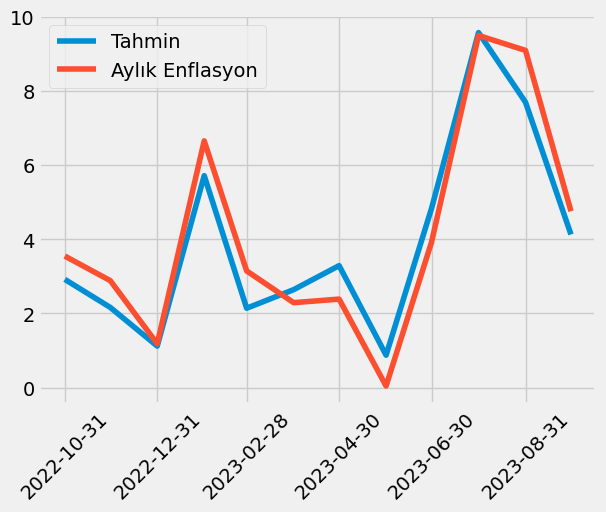

In [44]:
tahminler["Ortalama"]=tahminler.iloc[:,1:].mean(axis=1)
plt.plot(tahminler["Kernel Regression"],label="Tahmin")
plt.plot(tahminler["Aylık Enflasyon"],label="Aylık Enflasyon")
plt.xticks(pd.date_range(start="2022-10",periods=len(tahminler),freq="1M")[::2],rotation=45)
plt.legend()
plt.show()

In [45]:
from statsmodels.tsa.arima.model import ARIMA

model = SARIMAX(df6["USD/TL"].head(213), order=(0,2,1),seasonal_order=(0,0,0,12),trend='c')
model_fit = model.fit()
usdtahmin = model_fit.forecast(steps=26)
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USDTL"]
row=pd.DataFrame({"USDTL":df6.iloc[208:,0]},index=pd.date_range(start="2023-06-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([row,usdtahmin],axis=0)
usdtahmin

,USDTL
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.670384
2023-12-31,29.498688
2024-01-31,30.331025
2024-02-29,31.167397
2024-03-31,32.007802


In [46]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import month_plot
import warnings


model = SARIMAX(df14["Brent"], order=(1, 1, 0),seasonal_order=(1,0,1,6))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
brenttahmin=pd.DataFrame(forecast_values)
brenttahmin.columns=["Brent"]
row=pd.DataFrame({"Brent":df14.iloc[209:214,0]},index=pd.date_range(start="2023-07-30",end="2023-12-29",freq="1M"))
brenttahmin=pd.concat([row,brenttahmin],axis=0)
brenttahmin

,Brent
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.722381
2023-10-31,90.595909
2023-11-30,85.020000
2023-12-31,83.844885
2024-01-31,81.181574
2024-02-29,80.080654
2024-03-31,78.450555
2024-04-30,78.618020


In [47]:
model = SARIMAX(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"], order=(2,1,2),seasonal_order=(1,0,0,3))
model_fit = model.fit()
perakendetahmin = model_fit.forecast(steps=28)
perakendetahmin=pd.DataFrame(perakendetahmin)
perakendetahmin.columns=["Perakende"]
row=pd.DataFrame({"Perakende":perakende1.iloc[163:,0]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
perakendetahmin=pd.concat([row,perakendetahmin],axis=0)
perakendetahmin

,Perakende
2023-08-31,184.907520
2023-09-30,184.401177
2023-10-31,175.903694
2023-11-30,175.203800
2023-12-31,173.058321
2024-01-31,173.969571
2024-02-29,176.655623
2024-03-31,176.789997
2024-04-30,174.106565
2024-05-31,173.044359


In [48]:
model = SARIMAX(money["Para Arzi"].iloc[:-1], order=(0,2,2))
model_fit = model.fit()


# Gelecekteki değerleri tahmin edin
n_forecast = 26 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
paraarzitahmin=pd.DataFrame(forecast_values)
paraarzitahmin.columns=["Para Arzi"]
paraarzitahmin=pd.concat([pd.DataFrame({"Para Arzi":money.iloc[209:213,0]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M")),paraarzitahmin],axis=0)
paraarzitahmin

,Para Arzi
2023-07-31,114.784753
2023-08-31,120.253200
2023-09-30,123.493114
2023-10-31,127.637320
2023-11-30,132.383352
2023-12-31,137.068033
2024-01-31,141.752715
2024-02-29,146.437396
2024-03-31,151.122078
2024-04-30,155.806759


In [49]:
model = SARIMAX(kfaiz["Kredi Faizi"].iloc[:-1], order=(1,1,0),seasonal_order=(0,0,0,12))
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kfaiztahmin=pd.DataFrame(forecast_values)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:-1,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.765000
2023-09-30,56.350000
2023-10-31,59.392500
2023-11-30,60.860195
2023-12-31,61.568208
2024-01-31,61.909752
2024-02-29,62.074512
2024-03-31,62.153992
2024-04-30,62.192333
2024-05-31,62.210829


In [50]:
model = ARIMA(mfaiz, order=(3, 1, 1))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
mfaiztahmin=pd.DataFrame(forecast_values)
mfaiztahmin.columns=["Mevduat Faizi"]
new_row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2023-12-29",freq="1M"))
mfaiztahmin=pd.concat([new_row,mfaiztahmin],axis=0)
mfaiztahmin

,Mevduat Faizi
2023-08-31,29.412500
2023-09-30,41.656000
2023-10-31,43.892500
2023-11-30,45.175000
2023-12-31,51.438900
2024-01-31,50.748162
2024-02-29,50.248227
2024-03-31,52.680595
2024-04-30,52.035712
2024-05-31,51.564801


In [51]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=df6.iloc[:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=df6.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [52]:
exog=pd.DataFrame()
exog["X"]=df6["USD/TL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2006-03-31,82.598113
2006-04-30,93.884368
2006-05-31,96.222566
2006-06-30,103.560400
2006-07-31,116.361278
...,...
2023-07-31,1985.734693
2023-08-31,2303.136460
2023-09-30,2529.968892
2023-10-31,2483.938761


In [53]:
testexog=usdtahmin.rolling(2).mean().dropna().iloc[5:,0]*brenttahmin.iloc[5:,0]
testexog=testexog.dropna()

In [54]:
model = SARIMAX(motorin["Motorin"].iloc[38:],exog=exog,order=(1,0,0))
model=model.fit()


# Gelecekteki değerleri tahmin edin
n_forecast = 25 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model.get_forecast(steps=n_forecast,exog=testexog)
forecast_values = forecast.predicted_mean
motorintahmin=pd.DataFrame(forecast_values)
motorintahmin.columns=["Motorin"]
new_row=pd.DataFrame({"Motorin":motorin.iloc[-2:,0]},index=pd.date_range(start="2023-10-30",end="2023-12-29",freq="1M"))
motorintahmin=pd.concat([new_row,motorintahmin],axis=0)
motorintahmin

,Motorin
2023-10-31,38.900000
2023-11-30,38.980000
2023-12-31,39.309713
2024-01-31,38.908545
2024-02-29,39.153171
2024-03-31,39.150515
2024-04-30,39.963165
2024-05-31,41.343254
2024-06-30,42.634727
2024-07-31,42.763365


In [55]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,00,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-01-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0
2023-09-30,0
2023-10-31,0
2023-11-30,0
2023-12-31,0
2024-01-31,35
2024-02-29,0
2024-03-31,0
2024-04-30,0
2024-05-31,0


In [56]:
model = ARIMA(df3["Kredi"].iloc[:-1], order=(5, 2, 0))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kreditahmin=pd.DataFrame(forecast_values)
kreditahmin.columns=["Kredi"]
new_row=pd.DataFrame({"Kredi":df3["Kredi"].iloc[209:-1]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M"))
kreditahmin=pd.concat([new_row,kreditahmin],axis=0)
kreditahmin

,Kredi
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503
2023-11-30,106.225550
2023-12-31,110.790038
2024-01-31,114.099325
2024-02-29,115.878374
2024-03-31,119.374957
2024-04-30,122.213609


In [57]:
model = ARIMA(borc["Borç"], order=(0, 2, 1), seasonal_order=(0, 0, 0, 12))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 27# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
borctahmin=pd.DataFrame(forecast_values)
borctahmin.columns=["Borç"]
new_row=pd.DataFrame({"Borç":borc.iloc[161:,0]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M"))
borctahmin=pd.concat([new_row,borctahmin],axis=0)
borctahmin

,Borç
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09
2023-11-30,3.074094e+09
2023-12-31,3.181425e+09
2024-01-31,3.288757e+09
2024-02-29,3.396088e+09
2024-03-31,3.503419e+09
2024-04-30,3.610751e+09


In [58]:
model = SARIMAX(redk["REDK"], order=(1, 1, 2),trend='c')

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 27# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
redktahmin=pd.DataFrame(forecast_values)
redktahmin.columns=["REDK"]
new_row=pd.DataFrame({"REDK":[85.52,89.55,89.03]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
redktahmin=pd.concat([new_row,redktahmin],axis=0)
redktahmin

,REDK
2023-08-31,85.520000
2023-09-30,89.550000
2023-10-31,89.030000
2023-11-30,88.272991
2023-12-31,88.002239
2024-01-31,87.777102
2024-02-29,87.585270
2024-03-31,87.417756
2024-04-30,87.267999
2024-05-31,87.131207


In [59]:
model = SARIMAX(redkt["REDKT"], order=(1, 1, 2), seasonal_order=(1, 0, 0, 10),trend='c')

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 27# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
redkttahmin=pd.DataFrame(forecast_values)
redkttahmin.columns=["REDKT"]
new_row=pd.DataFrame({"REDKT":[52.39,55.46,55.90]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
redkttahmin=pd.concat([new_row,redkttahmin],axis=0)
redkttahmin

,REDKT
2023-08-31,52.390000
2023-09-30,55.460000
2023-10-31,55.900000
2023-11-30,54.460918
2023-12-31,53.079366
2024-01-31,52.018375
2024-02-29,51.359168
2024-03-31,50.888966
2024-04-30,51.523293
2024-05-31,51.517532


In [60]:
model = SARIMAX(m3["M3 Para Arzi"].iloc[:-1], order=(1, 2, 2),trend='c')

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
m3tahmin=pd.DataFrame(forecast_values)
m3tahmin.columns=["M3 Para Arzi"]
new_row=pd.DataFrame({"M3 Para Arzi":m3["M3 Para Arzi"].iloc[209:-1]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M"))
m3tahmin=pd.concat([new_row,m3tahmin],axis=0)
m3tahmin

,M3 Para Arzi
2023-07-31,117.729650
2023-08-31,123.434020
2023-09-30,126.660411
2023-10-31,130.933329
2023-11-30,135.271138
2023-12-31,140.348995
2024-01-31,144.846469
2024-02-29,149.873100
2024-03-31,154.496557
2024-04-30,159.500264


In [61]:
model = SARIMAX(pfaiz["Politika Faizi"].iloc[:-1], order=(1,1,1),seasonal_order=(0,0,0,12))
model_fit = model.fit()
faiztahmin = model_fit.forecast(steps=26)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[210:213,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin

,Politika Faizi
2023-08-31,23.500000
2023-09-30,31.000000
2023-10-31,33.000000
2023-11-30,35.383612
2023-12-31,37.256356
2024-01-31,38.727725
2024-02-29,39.883743
2024-03-31,40.791998
2024-04-30,41.505592
2024-05-31,42.066244


In [62]:
faiztahmin.columns=["Faiz"]
faiztahmin

,Faiz
2023-08-31,23.500000
2023-09-30,31.000000
2023-10-31,33.000000
2023-11-30,35.383612
2023-12-31,37.256356
2024-01-31,38.727725
2024-02-29,39.883743
2024-03-31,40.791998
2024-04-30,41.505592
2024-05-31,42.066244


In [63]:
faiztahmin.iloc[2:,0]

2023-10-31    33.000000
2023-11-30    35.383612
2023-12-31    37.256356
2024-01-31    38.727725
2024-02-29    39.883743
2024-03-31    40.791998
2024-04-30    41.505592
2024-05-31    42.066244
2024-06-30    42.506735
2024-07-31    42.852818
2024-08-31    43.124727
2024-09-30    43.338359
2024-10-31    43.506204
2024-11-30    43.638076
2024-12-31    43.741684
2025-01-31    43.823087
2025-02-28    43.887043
2025-03-31    43.937292
2025-04-30    43.976771
2025-05-31    44.007788
2025-06-30    44.032158
2025-07-31    44.051305
2025-08-31    44.066348
2025-09-30    44.078167
2025-10-31    44.087453
2025-11-30    44.094749
2025-12-31    44.100481
Freq: M, Name: Faiz, dtype: float64

In [64]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Politika Faizi"].iloc[95:-14]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Politika Faizi"].iloc[-14:-2],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [65]:
model=SARIMAX(issizlik.iloc[:-12,0],exog=exogtrain,order=(1,0,0),seasonal_order=(1,0,0,12))
model=model.fit()
forecast = model.get_forecast(steps=39,exog=exogtest)
forecast.predicted_mean


2022-10-31    10.173999
2022-11-30    10.170312
2022-12-31    10.187353
2023-01-31    10.146108
2023-02-28    10.213678
2023-03-31    10.157122
2023-04-30    10.201512
2023-05-31    10.189312
2023-06-30    10.198616
2023-07-31    10.159619
2023-08-31    10.138839
2023-09-30     9.972550
2023-10-31     9.927804
2023-11-30     9.890384
2023-12-31     9.854182
2024-01-31     9.833633
2024-02-29     9.798992
2024-03-31     9.789770
2024-04-30     9.764698
2024-05-31     9.751203
2024-06-30     9.727024
2024-07-31     9.710409
2024-08-31     9.688216
2024-09-30     9.688699
2024-10-31     9.682549
2024-11-30     9.674647
2024-12-31     9.668259
2025-01-31     9.660468
2025-02-28     9.656233
2025-03-31     9.648352
2025-04-30     9.643930
2025-05-31     9.637985
2025-06-30     9.634335
2025-07-31     9.629672
2025-08-31     9.626248
2025-09-30     9.619022
2025-10-31     9.613124
2025-11-30     9.607661
2025-12-31     9.602029
Freq: M, Name: predicted_mean, dtype: float64

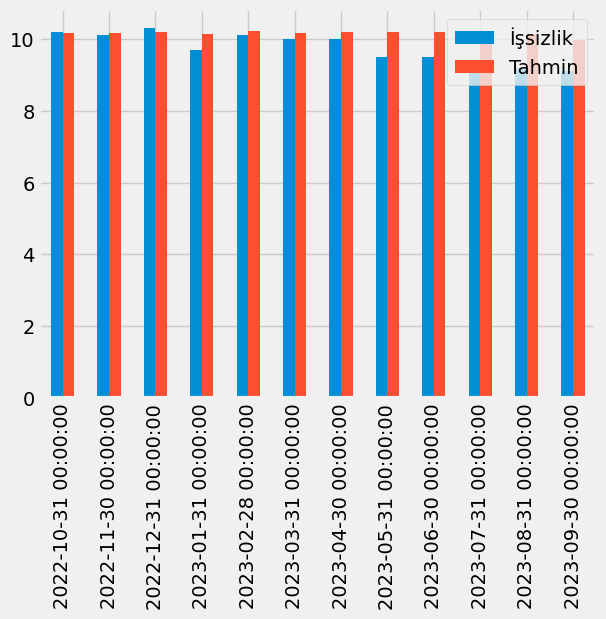

In [66]:
tahmin=pd.DataFrame()
tahmin["İşsizlik"]=issizlik.iloc[-12:,0]
tahmin["Tahmin"]=forecast.predicted_mean[:12]
tahmin.plot(kind="bar")
plt.show()

In [67]:

issizliktahmin=pd.DataFrame(forecast.predicted_mean[12:])
issizliktahmin.columns=["İşsizlik"]
#new_row=pd.DataFrame({"İşsizlik":[9.22]},index=pd.date_range(start="2023-09-30",end="2023-10-29",freq="1M"))
#issizliktahmin=pd.concat([new_row,issizliktahmin],axis=0)
issizliktahmin

,İşsizlik
2023-10-31,9.927804
2023-11-30,9.890384
2023-12-31,9.854182
2024-01-31,9.833633
2024-02-29,9.798992
2024-03-31,9.789770
2024-04-30,9.764698
2024-05-31,9.751203
2024-06-30,9.727024
2024-07-31,9.710409


In [68]:
model = SARIMAX(enf_belirsizlik["Enflasyon Belirsizliği"], order=(0, 1, 0),seasonal_order=(0,0,1,12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 26# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
enfbelirsizliktahmin=pd.DataFrame(forecast_values)
enfbelirsizliktahmin.columns=["Enflasyon Belirsizliği"]
new_row=pd.DataFrame({"Enflasyon Belirsizliği":enf_belirsizlik["Enflasyon Belirsizliği"].iloc[-4:]},index=pd.date_range(start="2023-08-30",end="2023-12-29",freq="1M"))
enfbelirsizliktahmin=pd.concat([new_row,enfbelirsizliktahmin],axis=0)
enfbelirsizliktahmin

,Enflasyon Belirsizliği
2023-08-31,6.810000
2023-09-30,7.300000
2023-10-31,5.570000
2023-11-30,4.490000
2023-12-31,4.564620
2024-01-31,4.751335
2024-02-29,4.335469
2024-03-31,4.298965
2024-04-30,4.324229
2024-05-31,4.196424


In [69]:
model = SARIMAX(sanayi["Sanayi"], order=(2, 1, 1), seasonal_order=(1, 0, 2, 12),trend='c')

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 28# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
sanayitahmin=pd.DataFrame(forecast_values)
sanayitahmin.columns=["Sanayi"]
new_row=pd.DataFrame({"Sanayi":[146.67,146.49]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
sanayitahmin=pd.concat([new_row,sanayitahmin],axis=0)
sanayitahmin

,Sanayi
2023-08-31,146.670000
2023-09-30,146.490000
2023-10-31,147.015032
2023-11-30,146.415436
2023-12-31,146.370779
2024-01-31,147.584579
2024-02-29,145.578765
2024-03-31,147.926838
2024-04-30,150.872413
2024-05-31,150.143267


In [70]:

model = SARIMAX(df6["USD/TL"].iloc[:-1], order=(0,2,1),seasonal_order=(0,0,0,12))
model_fit = model.fit()
usdtahmin = model_fit.forecast(steps=26)
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USDTL"]
row=pd.DataFrame({"USDTL":df6.iloc[207:-1,0]},index=pd.date_range(start="2023-05-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([row,usdtahmin],axis=0)
usdtahmin

,USDTL
2023-05-31,19.719514
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.674638
2023-12-31,29.503163
2024-01-31,30.331688
2024-02-29,31.160213


In [71]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin["USDTL"].rolling(3).mean(),paraarzitahmin["Para Arzi"].shift(1),motorintahmin["Motorin"],enfbelirsizliktahmin,perakendetahmin,sanayitahmin,kreditahmin.rolling(2).mean(),redktahmin,redkttahmin,m3tahmin.shift(1),borctahmin.shift(1)],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["Politika Faizi"]=faiztahmin["Faiz"]



tahmindf["Şok"]=0

tahmindf=tahmindf[['USDTL', 'Motorin', 'Perakende', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDK','REDKT','Şok','M3 Para Arzi','İşsizlik','Politika Faizi']]

tahmindf.columns=data.columns[:-1]
tahmindf=tahmindf.dropna(axis=0)
tahmindf=tahmindf.iloc[:-10,:]
tahmindf

,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,Şok,M3,İşsizlik,Politika Faizi
2023-11-30,2.047434,0.205656,-0.397885,60.860195,0.0,-0.407846,4.490000,3.355820,3.741984,1.756555,45.175000,-0.850286,-2.574387,0,3.373522,9.890384,35.383612
2023-12-31,3.010070,0.845851,-1.224562,61.568208,0.0,-0.030501,4.564620,3.718373,3.617793,2.841703,51.438900,-0.306720,-2.536777,0,3.312991,9.854182,37.256356
2024-01-31,2.889399,-1.020531,0.526556,61.909752,35.0,0.829264,4.751335,3.538724,3.491479,3.628207,50.748162,-0.255832,-1.998876,0,3.753836,9.833633,38.727725
2024-02-29,2.808257,0.628722,1.543978,62.074512,0.0,-1.359095,4.335469,3.417778,3.373687,2.262595,50.248227,-0.218545,-1.267258,0,3.204493,9.798992,39.883743
2024-03-31,2.731548,-0.006784,0.076065,62.153992,0.0,1.612923,4.298965,3.304827,3.263584,2.293976,52.680595,-0.191258,-0.915518,0,3.470317,9.789770,40.791998
2024-04-30,2.658919,2.075706,-1.517864,62.192333,0.0,1.991238,4.324229,3.199102,3.160440,2.692942,52.035712,-0.171312,1.246494,0,3.084914,9.764698,41.505592
2024-05-31,2.590051,3.453402,-0.610090,62.210829,0.0,-0.483287,4.196424,3.099932,3.063617,1.905464,51.564801,-0.156749,-0.011181,0,3.238718,9.751203,42.066244
2024-06-30,2.524661,3.123783,1.286910,62.219751,0.0,-0.550260,4.154610,3.006725,2.972549,2.116327,52.630493,-0.146130,-2.431088,0,2.962789,9.727024,42.506735
2024-07-31,2.462492,0.301720,1.017901,62.224055,0.0,1.082896,4.198246,2.918960,2.886739,2.646045,52.270992,-0.138400,-2.201248,0,3.045054,9.710409,42.852818
2024-08-31,2.403310,1.168521,-0.879442,62.226131,0.0,-0.740569,4.048701,2.836174,2.805745,2.076239,51.991181,-0.132782,-1.182152,0,2.842970,9.688216,43.124727


In [72]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'REDKT', 'Şok', 'İşsizlik', 'Politika Faizi']
X = data[features]
y=data["TÜFE"]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X, y)

tüfetahmin1 = []
result = 1749.04
sgdtahmin=reg.predict(tahmindf[features])
for i in range(len(sgdtahmin)):
    result *= (1 + sgdtahmin[i] / 100)
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2023-11-30", end="2025-03-27", freq="1M"))
tüfetahmin1

,SGD Regressor
2023-11-30,1794.130365
2023-12-31,1854.188172
2024-01-31,1943.921370
2024-02-29,2006.117122
2024-03-31,2072.692892
2024-04-30,2159.559376
2024-05-31,2241.350254
2024-06-30,2318.399046
2024-07-31,2397.622971
2024-08-31,2481.472800


In [73]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'Politika Faizi']


X= data[features]
model=LinearRegression()
model.fit(X, y)

tüfetahmin2 = []
result = 1749.04
lineartahmin = model.predict(np.array(tahmindf[features]))
lineartahmin=lineartahmin.ravel()
for i in range(len(lineartahmin)):
    result *= (1 + lineartahmin[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2023-11-30", end="2025-03-27", freq="1M"))
tüfetahmin2


,Linear Regression
2023-11-30,1787.702465
2023-12-31,1840.346544
2024-01-31,1921.503960
2024-02-29,1976.912632
2024-03-31,2036.263752
2024-04-30,2119.784413
2024-05-31,2195.163369
2024-06-30,2260.131762
2024-07-31,2326.984728
2024-08-31,2399.821349


In [74]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'İşsizlik', 'Politika Faizi']

X = data[features]
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X,y)


tüfetahmin5 = []
result = 1749.04
lassotahmin=reg.predict(tahmindf[features])
for i in range(len(lassotahmin)):
    result *= (1 + lassotahmin[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2023-11-30", end="2025-03-27", freq="1M"))
tüfetahmin5

,Lasso Regression
2023-11-30,1793.205456
2023-12-31,1851.138247
2024-01-31,1940.038802
2024-02-29,1999.111369
2024-03-31,2061.964449
2024-04-30,2144.019183
2024-05-31,2222.336284
2024-06-30,2296.189887
2024-07-31,2370.295783
2024-08-31,2449.295954


In [75]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'Politika Faizi']

X = data[features]
y=data["TÜFE"]
reg = linear_model.Lars(random_state=0)
reg.fit(X,y)



tüfetahmin6 = []
result = 1749.04
larstahmin=reg.predict(tahmindf[features])
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2023-11-30", end="2025-03-27", freq="1M"))
tüfetahmin6


,Lars Regression
2023-11-30,1787.702465
2023-12-31,1840.346544
2024-01-31,1921.503960
2024-02-29,1976.912632
2024-03-31,2036.263752
2024-04-30,2119.784413
2024-05-31,2195.163369
2024-06-30,2260.131762
2024-07-31,2326.984728
2024-08-31,2399.821349


In [76]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT', 'Politika Faizi']
X = data[features]
y=data["TÜFE"]
krr = KernelRidge()
krr.fit(X, y)

tüfetahmin7 = []
result = 1749.04
krrtahmin=krr.predict(tahmindf[features])
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2023-11-30", end="2025-03-27", freq="1M"))
tüfetahmin7

,Kernel Regression
2023-11-30,1783.399144
2023-12-31,1821.944510
2024-01-31,1888.758926
2024-02-29,1928.476830
2024-03-31,1968.572288
2024-04-30,2032.899387
2024-05-31,2089.462371
2024-06-30,2131.353459
2024-07-31,2172.576735
2024-08-31,2220.926427


In [77]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'Politika Faizi']

X = data[features]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
y=data["TÜFE"]
gpr.fit(X, y) 


tüfe = 1749.04  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin8 = []
gaustahmin=gpr.predict(tahmindf[features])
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2023-11-30",end="2025-03-27",freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2023-11-30,1785.743033
2023-12-31,1835.610285
2024-01-31,1913.018601
2024-02-29,1964.768826
2024-03-31,2020.062508
2024-04-30,2098.503176
2024-05-31,2169.232538
2024-06-30,2229.648328
2024-07-31,2291.088913
2024-08-31,2358.379721


In [78]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'İşsizlik', 'Politika Faizi']
X = data[features]
y=data["TÜFE"]
reg = linear_model.BayesianRidge()
reg.fit(X, y)


tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin9 = []
bayestahmin=reg.predict(tahmindf[features])
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2023-11-30",end="2025-03-27",freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2023-11-30,1797.551522
2023-12-31,1860.482019
2024-01-31,1955.064525
2024-02-29,2021.977124
2024-03-31,2094.190090
2024-04-30,2190.718924
2024-05-31,2281.477389
2024-06-30,2364.010837
2024-07-31,2448.681416
2024-08-31,2540.715166


In [79]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
#tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
#tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
#tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
#tüfetahmin.iloc[1,:]=tüfetahmin.iloc[1,:]+9.7
tüfetahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Ortalama
2023-11-30,1794.130365,1793.205456,1787.702465,1785.743033,1790.195330
2023-12-31,1854.188172,1851.138247,1840.346544,1835.610285,1845.320812
2024-01-31,1943.921370,1940.038802,1921.503960,1913.018601,1929.620683
2024-02-29,2006.117122,1999.111369,1976.912632,1964.768826,1986.727487
2024-03-31,2072.692892,2061.964449,2036.263752,2020.062508,2047.745900
2024-04-30,2159.559376,2144.019183,2119.784413,2098.503176,2130.466537
2024-05-31,2241.350254,2222.336284,2195.163369,2169.232538,2207.020611
2024-06-30,2318.399046,2296.189887,2260.131762,2229.648328,2276.092256
2024-07-31,2397.622971,2370.295783,2326.984728,2291.088913,2346.498099
2024-08-31,2481.472800,2449.295954,2399.821349,2358.379721,2422.242456


In [80]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[1:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[1:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[1:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[1:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]
'''
dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]

dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[8]]'''





dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








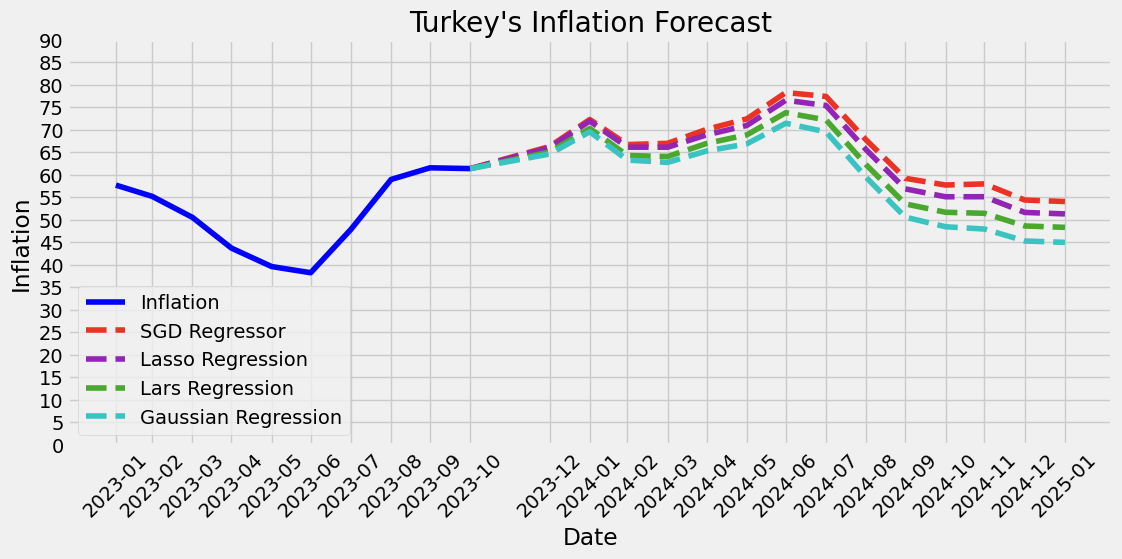

In [81]:








# Grafik çizdirelim
plt.figure(figsize=(12, 5))
plt.plot(df.iloc[191:201,1], label='Inflation', color='blue')
plt.plot(dfas.iloc[200:215,0],'--',label=dfas.columns[0], color='#EB3324')
plt.plot(dfas.iloc[200:215,1],'--',label=dfas.columns[1], color='#9325B5')
plt.plot(dfas.iloc[200:215,2],'--',label=dfas.columns[2], color='#4AA82E')
plt.plot(dfas.iloc[200:215,3],'--',label=dfas.columns[3], color='#39C4C2')
#plt.plot(dfas.iloc[200:215,4],'--',label=dfas.columns[4],color='#92BCC4')
#plt.plot(dfas.iloc[200:215,5],'--',label=dfas.columns[5],color='#AD4AC4')
#plt.plot(dfas.iloc[200:215,6],'--',label=dfas.columns[6],color='#DB8622')
#plt.plot(dfas.iloc[200:215,7],'--',label=dfas.columns[7])
#plt.plot(dfas.iloc[199:,8],'--',label=dfas.columns[8])
plt.xlabel('Date')
plt.ylabel('Inflation')
plt.xticks(dfas.iloc[191:215].index, dfas.iloc[191:215].index.strftime('%Y-%m'), rotation=45)
y_max = 100
y_min = 10
y_interval = 0.5
y_ticks = [0]
while y_ticks[-1] < 90:
    y_ticks.append(y_ticks[-1] + 5)









# Y ekseni etiketlerini ayarlama
plt.yticks(y_ticks)
plt.title("Turkey's Inflation Forecast")
plt.legend(loc=3)
plt.grid(True)
plt.show()


In [82]:
row=pd.DataFrame({"SGD Regressor":1749.04,"Lasso Regression":1749.04,"Lars Regression":1749.04,"Gaussian Regression":1749.04,"Ortalama":1749.04},index=pd.date_range(start="2023-10-30",periods=1,freq="1M"))
tüfetahmin=pd.concat([row,tüfetahmin],axis=0)
tüfetahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Ortalama
2023-10-31,1749.040000,1749.040000,1749.040000,1749.040000,1749.040000
2023-11-30,1794.130365,1793.205456,1787.702465,1785.743033,1790.195330
2023-12-31,1854.188172,1851.138247,1840.346544,1835.610285,1845.320812
2024-01-31,1943.921370,1940.038802,1921.503960,1913.018601,1929.620683
2024-02-29,2006.117122,1999.111369,1976.912632,1964.768826,1986.727487
2024-03-31,2072.692892,2061.964449,2036.263752,2020.062508,2047.745900
2024-04-30,2159.559376,2144.019183,2119.784413,2098.503176,2130.466537
2024-05-31,2241.350254,2222.336284,2195.163369,2169.232538,2207.020611
2024-06-30,2318.399046,2296.189887,2260.131762,2229.648328,2276.092256
2024-07-31,2397.622971,2370.295783,2326.984728,2291.088913,2346.498099


In [102]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin.iloc[0,:]=aylıktahmin.iloc[0,:]+1.69
aylıktahmin.iloc[1,:]=aylıktahmin.iloc[1,:]+0.57
aylıktahmin.iloc[2,:]=aylıktahmin.iloc[2,:]+0.16
aylıktahmin.iloc[6,:]=aylıktahmin.iloc[6,:]+0.53
aylıktahmin["Ortalama"]=aylıktahmin.mean(axis=1)
aylıktahmin["Medyan"]=aylıktahmin.median(axis=1)
aylıktahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Ortalama,Medyan
2023-11-30,4.268007,4.215126,3.900496,3.788467,4.043024,4.043024
2023-12-31,3.917461,3.800683,3.514790,3.362521,3.648951,3.648951
2024-01-31,4.999487,4.962481,4.569899,4.377034,4.727441,4.727441
2024-02-29,3.199499,3.044917,2.883610,2.705161,2.958534,2.958534
2024-03-31,3.318638,3.144051,3.002213,2.814259,3.070093,3.070093
2024-04-30,4.190996,3.979445,4.101662,3.883081,4.038956,4.038956
2024-05-31,4.317387,4.182817,4.085973,3.900467,4.121989,4.121989
2024-06-30,3.437606,3.323242,2.959615,2.785123,3.127044,3.127044
2024-07-31,3.417182,3.227342,2.957923,2.755618,3.090269,3.090269
2024-08-31,3.497207,3.332925,3.130086,2.937067,3.225052,3.225052


In [103]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2023-11-30",end="2025-03-27",freq="1M"))
tüfetahmin10.columns=["CPI"]


tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(28))
tüfetahmin11
    

,CPI
2022-11-30,84.389260
2022-12-31,64.269597
2023-01-31,57.682481
2023-02-28,55.179828
2023-03-31,50.508511
2023-04-30,43.684170
2023-05-31,39.585301
2023-06-30,38.213519
2023-07-31,47.831733
2023-08-31,58.943534


In [104]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin12 = []
krrtahmin=aylıktahmin["Gaussian Regression"]
krrtahmin=1+(krrtahmin/100)
for elem in krrtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin12.append(tüfe)
tüfetahmin12=pd.DataFrame(tüfetahmin12)
tüfetahmin12=tüfetahmin12.set_index(pd.date_range(start="2023-11-30",end="2025-03-27",freq="1M"))
tüfetahmin12.columns=["CPI"]
tüfetahmin12=pd.concat([df["CPI"],tüfetahmin12["CPI"]],axis=0)
tüfetahmin12=pd.DataFrame((tüfetahmin12.pct_change(periods=12)*100).tail(28))
tüfetahmin12

,CPI
2022-11-30,84.389260
2022-12-31,64.269597
2023-01-31,57.682481
2023-02-28,55.179828
2023-03-31,50.508511
2023-04-30,43.684170
2023-05-31,39.585301
2023-06-30,38.213519
2023-07-31,47.831733
2023-08-31,58.943534


In [105]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin13 = []
bayestahmin=aylıktahmin["SGD Regressor"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin13.append(tüfe)
tüfetahmin13=pd.DataFrame(tüfetahmin13)
tüfetahmin13=tüfetahmin13.set_index(pd.date_range(start="2023-11-30",end="2025-03-27",freq="1M"))
tüfetahmin13.columns=["CPI"]
tüfetahmin13=pd.concat([df["CPI"],tüfetahmin13["CPI"]],axis=0)
tüfetahmin13=pd.DataFrame((tüfetahmin13.pct_change(periods=12)*100).tail(28))
tüfetahmin13

,CPI
2022-11-30,84.389260
2022-12-31,64.269597
2023-01-31,57.682481
2023-02-28,55.179828
2023-03-31,50.508511
2023-04-30,43.684170
2023-05-31,39.585301
2023-06-30,38.213519
2023-07-31,47.831733
2023-08-31,58.943534


In [106]:
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["Maksimum"]=tüfetahmin13["CPI"]
yıllıktahmin["Minimum"]=tüfetahmin12["CPI"]
yıllıktahmin

,Ortalama,Maksimum,Minimum
2022-11-30,84.389260,84.389260,84.389260
2022-12-31,64.269597,64.269597,64.269597
2023-01-31,57.682481,57.682481,57.682481
2023-02-28,55.179828,55.179828,55.179828
2023-03-31,50.508511,50.508511,50.508511
2023-04-30,43.684170,43.684170,43.684170
2023-05-31,39.585301,39.585301,39.585301
2023-06-30,38.213519,38.213519,38.213519
2023-07-31,47.831733,47.831733,47.831733
2023-08-31,58.943534,58.943534,58.943534


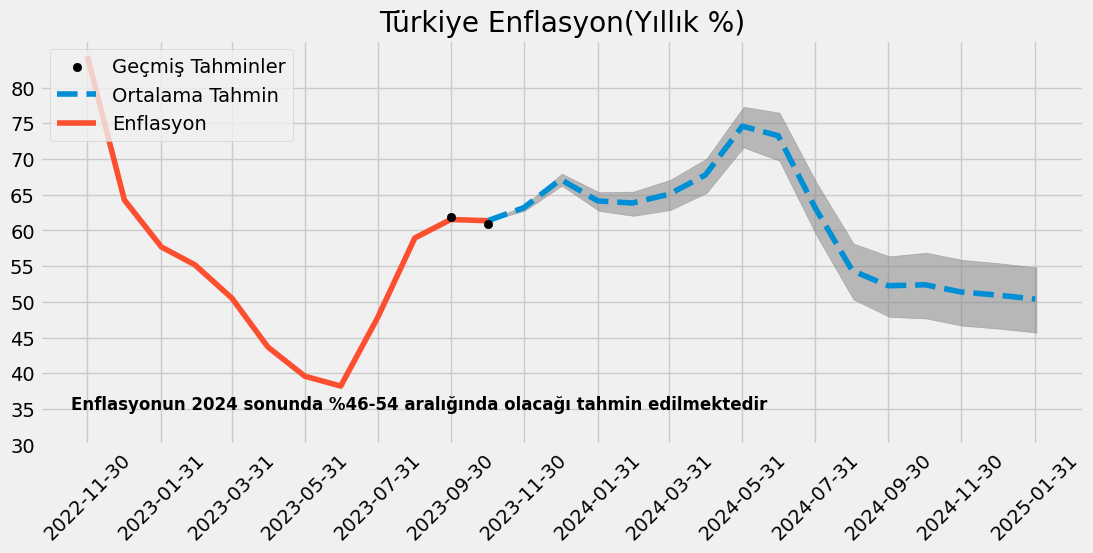

In [107]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(12,5))
plt.scatter(x=yıllıktahmin.index[10:12],y=[61.94,60.84],color='black',zorder=3,label='Geçmiş Tahminler')
plt.plot(yıllıktahmin["Ortalama"].iloc[11:27],'--',label="Ortalama Tahmin")
plt.plot(yıllıktahmin["Ortalama"].iloc[:12],label="Enflasyon")
plt.fill_between(yıllıktahmin.iloc[11:].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[11:].shift(1), yıllıktahmin["Minimum"].iloc[11:].shift(1), alpha=0.5, color='gray')
# Tarihi ekseni birimlerine dönüştürün
annotation_date = mdates.datestr2num('2024-06')

plt.text(annotation_date, 35, 'Enflasyonun 2024 sonunda %46-54 aralığında olacağı tahmin edilmektedir', fontsize=12, color='black', horizontalalignment='right',fontweight='bold')

plt.xticks(yıllıktahmin.index[::2],rotation=45)
plt.yticks(np.arange(30,85,5))
plt.title("Türkiye Enflasyon(Yıllık %)")
plt.legend(loc=2)
plt.show()
